# import

In [1]:
from simCAS import *
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import umap
from sklearn.decomposition import PCA
import episcanpy.api as epi
warnings.filterwarnings("ignore")

# Read real data

In [2]:
# read the anndata
prefix_='Buenrostro_2018'
resultdir='/data1/lichen/code/second/scATAC_integration/data/scATACdata_total/process/{0}/'.format(prefix_)
adata_dir=resultdir+'adata_forsimulation.h5ad'

adata=sc.read(adata_dir)
adata

AnnData object with n_obs × n_vars = 1931 × 169221
    obs: 'label', 'nb_features', 'log_nb_features', 'celltype'
    var: 'n_cells', 'commonness'

# Visulize the real data

In [3]:
# Perform Signac TF-IDF (count_mat: peak*cell)
def tfidf2(count_mat): 
    tf_mat = 1.0 * count_mat / np.tile(np.sum(count_mat,axis=0), (count_mat.shape[0],1))
    signac_mat = np.log(1 + np.multiply(1e4*tf_mat,  np.tile((1.0 * count_mat.shape[1] / (np.sum(count_mat,axis=1)+1) ).reshape(-1,1), (1,count_mat.shape[1]))))
    return scipy.sparse.csr_matrix(signac_mat)

In [4]:
nb_feature_selected=50000
adata_ori = epi.pp.select_var_feature(adata,
                                  nb_features=nb_feature_selected,
                                  show=False,
                                  copy=True)

sc.pp.filter_cells(adata_ori, min_counts=1)

adata_ori.X=tfidf2(adata_ori.X.T).T

pca=PCA(n_components=50, svd_solver='full')
X_pca = pca.fit_transform(adata_ori.X.toarray())
umap_=umap.UMAP(random_state=2022)
proj_ori = umap_.fit_transform(X_pca)

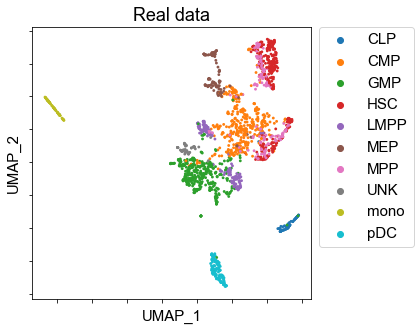

In [5]:
fig=plt.figure(figsize=(5,5))
adata_list=[adata_ori]
proj_list=[proj_ori]
title_list=['Real data']
for i in range(1):
    # X_pca = pca.transform(adata_list[i].X.toarray())
    # proj = umap_.transform(X_pca)
    proj=proj_list[i]
    ax_ = fig.add_subplot(1,1,i+1)
    df = {'UMAP_1':proj[:, 0],\
          'UMAP_2':proj[:, 1], \
          'label':adata_list[i].obs['celltype']}
    df = pd.DataFrame(df)
    ax = sns.scatterplot(x="UMAP_1", 
                         y="UMAP_2", 
                         hue="label",
                         edgecolor='none',
                         # hue_order=hue_order,
                         # saturation=1,
                         palette = 'tab10', 
                         s=8,linewidth = 0.0001, data=df)
    # ax.set(title='original UMAP',xlabel='UMAP_1')
    ax.set_xlabel('UMAP_1',fontsize=15)
    ax.set_ylabel('UMAP_2',fontsize=15)
    ax.set_title(title_list[i],fontsize=18)
    axLine, axLabel = ax.get_legend_handles_labels()
    ax.legend([],[],frameon=False)
    ax.set_xticklabels([''  for t in ax.get_xticklabels()])
    ax.set_yticklabels([''  for t in ax.get_yticklabels()])
fig.legend(axLine, axLabel,           
             loc = 2, 
           bbox_to_anchor = (0.9,0.9),
            fontsize=15,)

# generate synthetic data

the meanings of parameters are shown below:

In [6]:
?simCAS_generate

Signature:
simCAS_generate(
    peak_mean=None,
    lib_size=None,
    nozero=None,
    n_peak=100000.0,
    n_cell_total=1500,
    rand_seed=2022,
    zero_prob=0.5,
    zero_set='all',
    effect_mean=0,
    effect_sd=1,
    min_popsize=300,
    min_pop=None,
    tree_text=None,
    pops_name=None,
    pops_size=None,
    embed_mean_same=1,
    embed_sd_same=0.5,
    embed_mean_diff=1,
    embed_sd_diff=0.5,
    len_cell_embed=12,
    n_embed_diff=10,
    n_embed_same=2,
    simu_type='discrete',
    correct_iter=2,
    activation='exp_linear',
    two_embeds=True,
    adata_dir=None,
    lib_simu='estimate',
    distribution='Poisson',
    bw_pm=0.0001,
    bw_lib=0.05,
    bw_nozero=0.05,
    real_param=False,
    K=None,
    A=None,
    stat_estimation='one_logser',
)
Docstring:
generate scCAS data with three modes: pseudo-cell-type mode, discrete mode, continuous mode.

Parameter
----------
peak_mean: 1D numpy array, default=None
    Real peak mean of scCAS data. Used for statist

In [7]:
adata_final=simCAS_generate(adata_dir=adata_dir,n_peak=adata.shape[1],
                            n_cell_total=adata.shape[0],rand_seed=2022,simu_type='cell_type',
                    activation='sigmod',stat_estimation='one_logser')

**********start generate effect vector...**********
**********generate effect finished!**********
**********start generate cell embedding...**********
simulation type is cell_type
simulating cell type: CLP...
simulating cell type: CMP...
simulating cell type: GMP...
simulating cell type: HSC...
simulating cell type: LMPP...
simulating cell type: MEP...
simulating cell type: MPP...
simulating cell type: UNK...
simulating cell type: mono...
simulating cell type: pDC...
**********start ZIP correction...**********
**********ZIP correction finished!**********
**********generate counts finshed!**********


In [8]:
adata_final

AnnData object with n_obs × n_vars = 1931 × 169221
    obs: 'celltype'

# Visualization on the real data UMAP space

In [9]:
adata_final.var=adata.var
adata_simCAS=adata_final[:,adata_ori.var_names]
sc.pp.filter_cells(adata_simCAS, min_counts=1)
adata_simCAS.X=tfidf2(adata_simCAS.X.T).T

In [10]:
X_pca = pca.transform(adata_simCAS.X.toarray())
proj_simCAS = umap_.transform(X_pca)

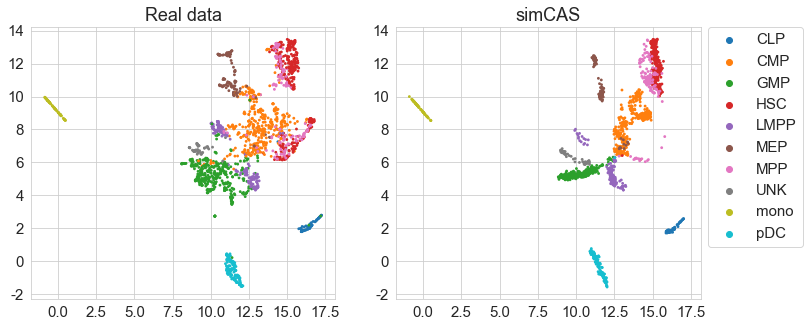

In [11]:
sns.set_style("whitegrid")
celltypes=np.unique(list(adata_ori.obs.celltype))
fig=plt.figure(figsize=(12,5))
adata_list=[adata_ori,adata_simCAS]
proj_list=[proj_ori,proj_simCAS]
title_list=['Real data','simCAS']
for i in range(2):
    # X_pca = pca.transform(adata_list[i].X.toarray())
    # proj = umap_.transform(X_pca)
    proj=proj_list[i]
    ax_ = fig.add_subplot(1,2,i+1)
    df = {'UMAP_1':proj[:, 0],\
          'UMAP_2':proj[:, 1], \
          'label':adata_list[i].obs['celltype']}
    df = pd.DataFrame(df)
    ax = sns.scatterplot(x="UMAP_1", 
                         y="UMAP_2", 
                         hue="label",
                         edgecolor='none',
                         hue_order=celltypes,
                         # saturation=1,
                         palette = 'tab10', 
                         s=8,linewidth = 0.0001, data=df)
    plt.xticks(rotation=0,fontsize=15)
    plt.yticks(rotation=0,fontsize=15)
    
    # ax.set(title='original UMAP',xlabel='UMAP_1')
    ax.set_xlabel('')
    ax.set_ylabel('')
    if i>0:
        ax.set_xlim(lim1_x,lim2_x)
        ax.set_ylim(lim1_y,lim2_y)
    ax.set_title(title_list[i],fontsize=18)
    axLine, axLabel = ax.get_legend_handles_labels()
    ax.legend([],[],frameon=False)
    # ax.set_xticklabels([''  for t in ax.get_xticklabels()])
    # ax.set_yticklabels([''  for t in ax.get_yticklabels()])
    
    if i==0:
        lim1_y,lim1_x,lim2_y,lim2_x=ax.get_ylim()[0],ax.get_xlim()[0],ax.get_ylim()[1],ax.get_xlim()[1]
fig.legend(axLine, axLabel,           
             loc = 2, 
           bbox_to_anchor = (0.9,0.9),
            fontsize=15,)